In [ ]:
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Projects'

/content/drive/MyDrive/Projects


In [ ]:
#!pip install pennylane
#!pip install pennylane-qiskit
#!pip install qiskit
#!pip install pennylane-qchem

!pip install pyscf

#!pip install pylatexenc
#!pip install --update openfermion

from IPython.display import clear_output
clear_output()

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [ ]:
from qiskit import IBMQ

from qiskit import *
from qiskit.providers.aer.noise import NoiseModel

configrc.store_credentials:WARNING:2020-12-24 16:54:14,775: Credentials already present. Set overwrite=True to overwrite.


In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# FCI

In [ ]:
from pyscf import gto, scf, ao2mo, fci
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def FCI(L, e_list):
  mol = gto.M(atom='H 0 0 ' + str(L) + '; H 0 0 0', basis='sto-3g')
  mf = scf.RHF(mol).run()
  h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
  eri = ao2mo.kernel(mol, mf.mo_coeff)
  cisolver = fci.direct_spin1.FCI(mol)
  e, ci = cisolver.kernel(h1, eri, h1.shape[1], mol.nelec, ecore=mol.energy_nuc())
  e_list += [e]
  return e_list
  #print(e)

In [ ]:
FCI(0.7414, [])

converged SCF energy = -1.11668438708534


[-1.1372701746609022]

In [ ]:
e_fci = []

bond_length_fci = np.linspace(0.1, 3.0, 30)

for i in range(len(bond_length_fci)):
  e_fci = FCI(bond_length_fci[i], e_fci)

from IPython.display import clear_output
clear_output()

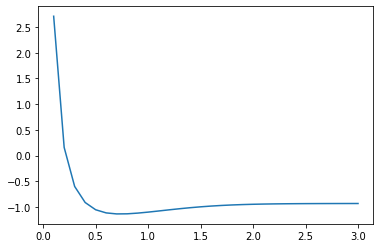

In [ ]:
plt.plot(bond_length_fci, e_fci)

In [ ]:
bond_length_fci[np.argmin(e_fci)]

0.7

In [ ]:
np.savetxt('./FCI_energy_wide_30.txt', e_fci)
#np.savetxt('./FCI_length_crammed.txt', bond_length_fci)

In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

# VQE

## Molecule Geometry

In [ ]:
f = open("./h2.xyz")
f.read()

'2\nin Angstrom\nH          0.00000        0.00000        0.00000\nH          0.00000        0.00000        0.750000\n'

In [ ]:
def change_geometry(L_new, L_prev):
  #read input file
  fin = open("./h2.xyz", "rt")
  #read file contents to string
  data = fin.read()
  #replace all occurrences of the required string
  data = data.replace(str(L_prev), str(L_new))
  #close the input file
  fin.close()
  #open the input file in write mode
  fin = open("./h2.xyz", "wt")
  #overrite the input file with the resulting data
  fin.write(data)
  #close the file
  fin.close()
  return L_new

In [ ]:
change_geometry(0.10, 0.90)

0.1

## Jordan-Wigner Mapping

In [ ]:
def jordan_wigner_map():
  geometry = './h2.xyz'
  charge = 0
  multiplicity = 1
  basis_set = 'sto-3g'
  name = 'h2'

  h, qubits = qchem.molecular_hamiltonian(
      name,
      geometry,
      charge=charge,
      mult=multiplicity,
      basis=basis_set,
      active_electrons=2,
      active_orbitals=2,
      mapping='jordan_wigner'
  )

  #print('Number of qubits = ', qubits)
  #print('Hamiltonian is ', h)

  return h

In [ ]:
print(jordan_wigner_map())

(5.060740822127862) [I0]
+ (0.30083789386566806) [Z0]
+ (0.300837893865668) [Z1]
+ (-0.726476789977057) [Z2]
+ (-0.7264767899770572) [Z3]
+ (0.19297139907187022) [Z0 Z1]
+ (0.03904256477431653) [Y0 X1 X2 Y3]
+ (-0.03904256477431653) [Y0 Y1 X2 X3]
+ (-0.03904256477431653) [X0 X1 Y2 Y3]
+ (0.03904256477431653) [X0 Y1 Y2 X3]
+ (0.15204536016841363) [Z0 Z2]
+ (0.19108792494273016) [Z0 Z3]
+ (0.19108792494273016) [Z1 Z2]
+ (0.15204536016841363) [Z1 Z3]
+ (0.2030711100007584) [Z2 Z3]


## Devices

In [ ]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [ ]:
dev_noisy = qml.device("qiskit.aer", wires=qubits, shots=2048, noise_model = noise_model, analytic=False, backend='qasm_simulator')
cost_noisy = qml.ExpvalCost(circuit, h, dev_noisy)

## Ground State Energy as function of bond length

In [ ]:
max_iterations = 1000
conv_tol = 1e-08

qubits = 4

energy_list = []
bond_length_vqe = np.linspace(0.73, 0.75, 20)

L_before = 0.80

for k in range(len(bond_length_vqe)):

  L = bond_length_vqe[k]

  L_before = change_geometry(L, L_before)

  dev = qml.device('default.qubit', wires=qubits)

  def circuit(params, wires):
      #qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
      for i in wires:
          qml.Rot(*params[i], wires=i)
      qml.CNOT(wires=[2, 3])
      qml.CNOT(wires=[2, 0])
      qml.CNOT(wires=[3, 1])

  h = jordan_wigner_map()

  cost_fn = qml.ExpvalCost(circuit, h, dev)

  opt = qml.AdamOptimizer(stepsize=0.01)
  np.random.seed(0)
  params = np.random.normal(0, np.pi, (qubits, 3))

  prev_energy = cost_fn(params)

  for n in range(max_iterations):
      params = opt.step(cost_fn, params)
      energy = cost_fn(params)
      conv = np.abs(energy - prev_energy)

      if conv <= conv_tol:
          break

      prev_energy = energy

  energy_list += [energy]
  print()
  print('Bond Length = {:.4f} Angstrom'.format(L))
  print('Final convergence parameter = {:.8f} Ha'.format(conv))
  print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
  print()




Bond Length = 0.73 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of the ground-state energy = -1.13728561 Ha


Bond Length = 0.73 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of the ground-state energy = -1.13729350 Ha


Bond Length = 0.73 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of the ground-state energy = -1.13729945 Ha


Bond Length = 0.73 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of the ground-state energy = -1.13730349 Ha


Bond Length = 0.73 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of the ground-state energy = -1.13730562 Ha


Bond Length = 0.74 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of the ground-state energy = -1.13730585 Ha


Bond Length = 0.74 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of the ground-state energy = -1.13730420 Ha


Bond Length = 0.74 Angstrom
Final convergence parameter = 0.00000001 Ha
Final value of th

In [ ]:
np.savetxt('./VQE_energy_vs_L_crammed.txt', energy_list)
np.savetxt('./VQE_length_crammed.txt', bond_length_vqe)

## Ground State Energy as function of number of iterations (fixed bond length)

In [ ]:
change_geometry(0.7414, 0.7348650)

0.7414

In [ ]:
f = open("./h2.xyz")
f.read()

'2\nin Angstrom\nH          0.00000        0.00000        0.00000\nH          0.00000        0.00000        0.74140000\n'

In [ ]:
h = jordan_wigner_map()
print(h)

(-0.09886396933545721) [I0]
+ (0.17119774903432944) [Z0]
+ (0.17119774903432936) [Z1]
+ (-0.22278593040418498) [Z2]
+ (-0.22278593040418496) [Z3]
+ (0.16862219158920938) [Z0 Z1]
+ (0.04532220205287401) [Y0 X1 X2 Y3]
+ (-0.04532220205287401) [Y0 Y1 X2 X3]
+ (-0.04532220205287401) [X0 X1 Y2 Y3]
+ (0.04532220205287401) [X0 Y1 Y2 X3]
+ (0.120544822053018) [Z0 Z2]
+ (0.165867024105892) [Z0 Z3]
+ (0.165867024105892) [Z1 Z2]
+ (0.120544822053018) [Z1 Z3]
+ (0.17434844185575687) [Z2 Z3]


In [ ]:
qubits = 4

dev = qml.device('default.qubit', wires=qubits)

def circuit(params, wires):
    #qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
    for i in wires:
        qml.Rot(*params[i], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

  
cost_fn = qml.ExpvalCost(circuit, h, dev)

opt = qml.AdamOptimizer(stepsize=0.01)
np.random.seed(0)
params = np.random.normal(0, np.pi, (qubits, 3))

In [ ]:
max_iterations = 1000
conv_tol = 1e-08

energy_list = []

prev_energy = cost_fn(params)
energy_list += [prev_energy]

for n in range(max_iterations):
    params = opt.step(cost_fn, params)
    energy = cost_fn(params)
    conv = np.abs(energy - prev_energy)

    if (n+1) % 20 == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha'.format(n+1, energy))

    if conv <= conv_tol:
        break

    prev_energy = energy
    energy_list += [prev_energy]

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print('Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)'.format(
    np.abs(energy - (-1.136189454088)), np.abs(energy - (-1.136189454088))*627.503
    )
)
print()
print('Final circuit parameters = \n', params)

Iteration = 20,  Energy = 0.11794595 Ha
Iteration = 40,  Energy = 0.00870996 Ha
Iteration = 60,  Energy = -0.11372095 Ha
Iteration = 80,  Energy = -0.23432854 Ha
Iteration = 100,  Energy = -0.34290964 Ha
Iteration = 120,  Energy = -0.44178559 Ha
Iteration = 140,  Energy = -0.54365110 Ha
Iteration = 160,  Energy = -0.65951615 Ha
Iteration = 180,  Energy = -0.78372569 Ha
Iteration = 200,  Energy = -0.89679510 Ha
Iteration = 220,  Energy = -0.98359794 Ha
Iteration = 240,  Energy = -1.04249915 Ha
Iteration = 260,  Energy = -1.08028547 Ha
Iteration = 280,  Energy = -1.10421240 Ha
Iteration = 300,  Energy = -1.11906199 Ha
Iteration = 320,  Energy = -1.12786286 Ha
Iteration = 340,  Energy = -1.13275967 Ha
Iteration = 360,  Energy = -1.13528742 Ha
Iteration = 380,  Energy = -1.13648213 Ha
Iteration = 400,  Energy = -1.13699153 Ha
Iteration = 420,  Energy = -1.13718422 Ha
Iteration = 440,  Energy = -1.13724763 Ha
Iteration = 460,  Energy = -1.13726533 Ha
Iteration = 480,  Energy = -1.13726938 H

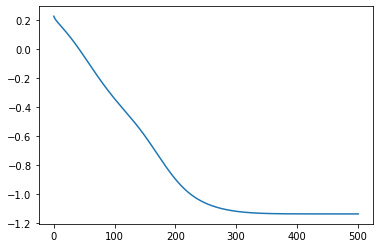

In [ ]:
plt.plot(energy_list)

In [ ]:
bond_length_vqe = np.linspace(0, len(energy_list)-1, len(energy_list), dtype=int)

In [ ]:
np.savetxt('./VQE_energy_vs_iteration.txt', energy_list)
np.savetxt('./VQE_length_iteration.txt', bond_length_vqe)

## Ground state wave function estimation using the final (optimal) circuit parameters

In [ ]:
params

array([[ 5.54193389e+00,  3.14092053e+00,  3.07479606e+00],
       [ 7.03997361e+00,  3.14155227e+00, -3.07020901e+00],
       [ 2.98479079e+00, -2.26136252e-01, -1.55282882e-13],
       [ 1.28993323e+00,  9.38358209e-08,  4.56873496e+00]])

In [ ]:
dev = qml.device('default.qubit', wires=4, shots=10000)

@qml.qnode(dev)
def circuit_optimal(params):
    #qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
    for i in range(4):
        qml.Rot(*params[i], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])
    return qml.probs([0, 1, 2, 3])

In [ ]:
prob_state = circuit_optimal(params)

In [ ]:
print(prob_state[3] + prob_state[12])
print(prob_state[3], np.sqrt(prob_state[3]))
print(prob_state[12], np.sqrt(prob_state[12]))

0.9999998866556078
0.01273001216039701 0.11282735554995965
0.9872698744952108 0.9936145502634363


In [ ]:
prob_state

array([4.54581886e-17, 2.45441679e-22, 1.14247651e-26, 1.27300122e-02,
       1.11499004e-07, 1.00066671e-31, 2.80224526e-17, 5.19003104e-12,
       4.02510322e-10, 2.17326762e-15, 1.29027530e-33, 1.43768560e-09,
       9.87269874e-01, 8.86042076e-25, 3.16476340e-24, 5.86144993e-19])

In [ ]:
np.savetxt('./VQE_optimal_param_0.7414.txt', params)